In [1]:
import pickle
import numpy as np

In [2]:
with open('/kaggle/input/chatbot-train-and-test-data/train_qa.txt','rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('/kaggle/input/chatbot-train-and-test-data/test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [4]:
type(test_data)

list

In [5]:
len(train_data)

10000

In [6]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [7]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [8]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [9]:
all_data = test_data + train_data

len(all_data)

11000

In [10]:
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [11]:
vocab.add('no')
vocab.add('yes')

In [12]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [13]:
vocab_len = len(vocab) + 1

In [14]:
vocab_len

38

In [15]:
all_story_lens = [len(data[0]) for data in all_data]

In [16]:
max_story_len = max(all_story_lens)

In [17]:
max_question_len = max([len(data[1]) for data in all_data])

In [18]:
max_story_len

156

In [19]:
#all_story_lens

In [20]:
max_question_len

6

In [21]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
tokenizer = Tokenizer(filters=[])

In [23]:
tokenizer.fit_on_texts(vocab)

In [24]:
tokenizer.word_index

{'got': 1,
 'there': 2,
 'took': 3,
 'down': 4,
 'bathroom': 5,
 'mary': 6,
 'football': 7,
 '.': 8,
 'no': 9,
 'discarded': 10,
 'left': 11,
 'dropped': 12,
 'bedroom': 13,
 'the': 14,
 'milk': 15,
 'travelled': 16,
 'yes': 17,
 '?': 18,
 'apple': 19,
 'in': 20,
 'daniel': 21,
 'went': 22,
 'hallway': 23,
 'put': 24,
 'sandra': 25,
 'grabbed': 26,
 'john': 27,
 'is': 28,
 'to': 29,
 'back': 30,
 'journeyed': 31,
 'garden': 32,
 'moved': 33,
 'up': 34,
 'office': 35,
 'picked': 36,
 'kitchen': 37}

In [25]:
train_story_text = []
train_question_text = []
train_answers =[]

In [26]:
for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [27]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):
    X = []

    Xq = []

    Y = []

    for story,query,answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]

        y = np.zeros(len(word_index) + 1)

        y[word_index[answer]] = 1

        X.append(x)

        Xq.append(xq)

        Y.append(y)


    return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len), np.array(Y))

In [28]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [29]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [30]:
len(inputs_test[1])

156

In [31]:
answers_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [32]:
len(answers_train[0])

38

In [33]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding,Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM,Reshape


In [34]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [35]:
vocab_size = len(vocab) + 1

input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

#(bathsize, storylen, 64)

In [36]:
max_question_len

6

In [37]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

#(batchsize, storylen, questionlen)

In [38]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

#(batch, question_len, 64) ---> (64, question_len)---> 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [40]:
input_encoded_m.shape
input_encoded_c.shape


(None, 156, 6)

In [41]:
match = dot([input_encoded_m, question_encoded],axes=(2,2))
match = Activation('softmax')(match)

#(story_len, question_len)

In [42]:
match.shape

(None, 156, 6)

In [43]:
input_encoded_c.shape

(None, 156, 6)

In [44]:
input_encoded_m.shape

(None, 156, 64)

In [45]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [46]:
response.shape

(None, 6, 156)

In [47]:
answer = concatenate([response,question_encoded])

In [48]:
answer

<KerasTensor shape=(None, 6, 220), dtype=float32, sparse=False, name=keras_tensor_18>

In [49]:
answer = LSTM(32)(answer)

In [50]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [51]:
answer = Activation('softmax')(answer)

In [54]:
model = Model([input_sequence,question],answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 156)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 156, 64)        │          2,432 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 6, 64)          │          2,432 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 156, 6)         │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 156, 6)         │              0 │ dot[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 156, 6)         │            228 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 156, 6)         │              0 │ activation[0][0],      │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 6, 156)         │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 6, 220)         │              0 │ permute[0][0],         │
│                           │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 32)             │         32,384 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 38)             │          1,254 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 38)             │              0 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,730 (151.29 KB)

 Trainable params: 38,730 (151.29 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit([inputs_train,queries_train],answers_train,batch_size=32,epochs=100,validation_data=([inputs_test,queries_test],answers_test))

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4876 - loss: 1.1784 - val_accuracy: 0.5030 - val_loss: 0.6946
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5095 - loss: 0.7088 - val_accuracy: 0.4970 - val_loss: 0.6968
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4849 - loss: 0.7017 - val_accuracy: 0.5120 - val_loss: 0.6932
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5069 - loss: 0.6962 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5097 - loss: 0.6946 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5064 - loss: 0.6956 - val_accuracy: 0.4970 - val_loss: 0.6934
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4998 - loss: 0.6955 - val_accuracy: 0.4970 - val_loss: 0.6953
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5086 - loss: 0.6945 - val_accu

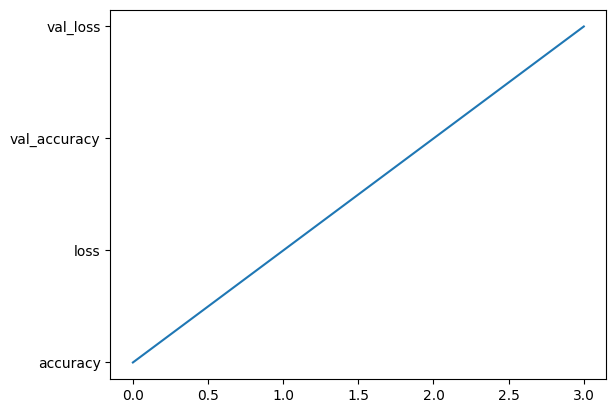

In [56]:
import matplotlib.pyplot as plt
plt.plot(history.history.keys())

Text(0.5, 0, 'epochs')

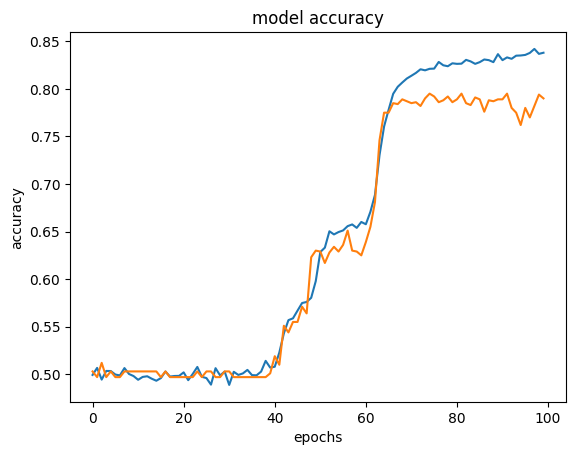

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')

In [59]:
model.save('chatbot_100.keras')

In [60]:
predicted = model.predict([inputs_test,queries_test])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [61]:
pred_classes = np.argmax(predicted, axis=1)

In [62]:
pred_classes.shape

(1000,)

In [63]:
predicted.shape

(1000, 38)

In [66]:
pred_classes[2]

17

In [67]:
pred_classes

array([ 9,  9, 17, 17,  9,  9,  9, 17,  9, 17, 17, 17,  9, 17, 17, 17, 17,
       17,  9, 17, 17,  9, 17,  9,  9, 17, 17, 17, 17, 17, 17,  9,  9, 17,
       17,  9, 17, 17, 17,  9, 17,  9,  9, 17, 17, 17, 17,  9, 17, 17, 17,
       17, 17, 17, 17,  9,  9, 17, 17,  9,  9, 17, 17, 17, 17, 17, 17, 17,
        9, 17,  9, 17,  9, 17, 17, 17, 17, 17,  9, 17, 17,  9, 17, 17,  9,
        9, 17,  9,  9, 17, 17,  9, 17,  9,  9, 17,  9, 17, 17,  9,  9,  9,
       17,  9,  9,  9,  9, 17,  9,  9, 17, 17, 17,  9, 17,  9, 17, 17, 17,
       17, 17, 17, 17, 17, 17,  9, 17,  9,  9,  9,  9, 17,  9, 17,  9,  9,
        9,  9,  9,  9,  9, 17,  9,  9, 17, 17,  9, 17, 17,  9, 17, 17,  9,
       17,  9,  9, 17, 17,  9, 17, 17, 17, 17, 17, 17,  9, 17,  9, 17, 17,
       17,  9,  9,  9, 17, 17, 17, 17,  9,  9, 17, 17, 17, 17,  9, 17, 17,
       17, 17,  9, 17, 17,  9, 17, 17, 17, 17,  9,  9, 17, 17, 17,  9, 17,
        9, 17, 17, 17, 17, 17, 17, 17,  9,  9,  9,  9, 17,  9, 17, 17, 17,
       17, 17, 17, 17, 17

In [68]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [69]:
new_story = "John left the kitchen . Sandra dropped the football in the garden ."

In [71]:
new_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [72]:
new_question = "Is the football in the garden ?"

In [73]:
new_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [74]:
newdata = [(new_story.split(), new_question.split(),'yes' )]

In [75]:
insert_story, insert_question, insert_answer = vectorize_stories(newdata)

In [76]:
chat_preds = model.predict([insert_story,insert_question])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [78]:
pred = np.argmax(chat_preds,axis=1)

In [80]:
for key,value in tokenizer.word_index.items():
    if value == pred:
        print(key)

yes
